# Provide Manual Annotations for Training Set and Check Individual Predictions also on Training Set

## Expected folder structure
A main folder ("Data Folder") should be given as input to this notebook. It will then look for nested folders inside this main folder and collect paths to '.tif' files. It will randomly split these paths into "train" and "validation" paths, and copy the files to these respective folders. Then, it will look for a "control" folder and copy the files from there also to the "train" folder.
```
Data Folder
|
├─ Patient 8
|    |
|    ├─ Day 9
|    |    |
|    |    ├─ media1.tif
|    |    ├─ media2.tif
|    |    ⁞
|    |
|    └─ Day 21
|         |
|         ├─ media1.tif
|         ├─ media2.tif
|         ⁞
|
├─ Patient 10
|    |
|    ├─ Day 9
|    |    |
|    |    ├─ media1.tif
|    |    ├─ media2.tif
|    |    ⁞
|    |
|    └─ Day 21
|         |
|         ├─ media1.tif
|         ├─ media2.tif
|         ⁞
|
├─ control
|   |
|   ├─ control_image1.tif
|   ⁞
⁞
```

In [4]:
import napari
from napari.utils import nbscreenshot
from pathlib import Path
from skimage.io import imread, imsave
import random
import numpy as np
import shutil
import apoc
import matplotlib.pyplot as plt
from natsort import natsorted
import json

from utilities import get_layer_position, refine_labels

# Fixed seed for now for reproducibility
seed = 42
random.seed(seed)

## 1. Provide inputs

Folder to images and number of images in training and validation sets

In [5]:
folder_path = r"D:\Datasets\Claudia Dagostino\data"
n_train, n_validation = 6, 2
min_area = 1000

folder_path = Path(folder_path)

## 2. Create train and validation folders by randomnly copying some images to these new folders

Run the cell below once to create two folders with train and validation images.
Running it a second time raises an error. This is intentional to avoid overwritting the newly created folders.
If you really want to create these folders again, please delete them manually and re-run the cell below.

In [6]:
path_list = [path for path in folder_path.rglob("*") if (
    (path.is_file()) 
    and (path.suffix == '.tif')
    and ('train' not in path.parts)
    and ('validation' not in path.parts)
    and ('Outputs' not in path.parts)
    and ('train_annotations' not in path.parts)
    and ('control' not in path.parts))]

# Get 'control' folder paths
control_path_list = [path for path in folder_path.rglob("*") if (
    (path.is_file()) 
    and (path.suffix == '.tif')
    and ('control' in path.parts))]

# Get some paths for training
train_paths = random.choices(path_list, k=n_train)
# Create a train folder (raises error if folder already exist to avoid overwriting files)
training_set_folder_path = folder_path / 'train'
try:
    training_set_folder_path.mkdir(exist_ok = False)
except FileExistsError:
    print('Warning! Folder ', training_set_folder_path, ' already exists. To create a new training set, manually delete the folder and run this cell again.')
    raise
# Copy files to train folder
_ = [shutil.copy(path, training_set_folder_path / (path.stem + '.tif')) for path in train_paths]
# Copy files from control folder to train folder
_ = [shutil.copy(path, training_set_folder_path / (path.stem + '.tif')) for path in control_path_list]

# update path list with just remaining paths
path_list = [path for path in path_list if path not in train_paths]
# Get some paths for validation
validation_paths = random.choices(path_list, k=n_validation)
# Create a validation folder (raises error if folder already exist to avoid overwriting files)
validation_set_folder_path = folder_path / 'validation'
try:
    validation_set_folder_path.mkdir(exist_ok = False)
except FileExistsError:
    print('Warning! Folder ', validation_set_folder_path, ' already exists. To create a new validation set, manually delete the folder and run this cell again.')
    raise
# Copy files to validation folder
_ = [shutil.copy(path, validation_set_folder_path / (path.stem + '.tif')) for path in validation_paths]

## 3. Open training images and annotate them

Load train images paths and, if existing, annotation images as napari layers. Manual annotations will only be loaded if the 'train_annotations' folder is populated with the same number of images as the 'train' folder with the same file names. Otherwise, empty annotation layers will be created.

In [7]:
training_set_folder_path = folder_path / 'train'
training_annotations_folder_path = folder_path / 'train_annotations'
# Create training annotations folder if it does not exist yet
if training_annotations_folder_path.exists() ==  False:
    training_annotations_folder_path.mkdir(exist_ok = True)

train_images_paths = [path for path in training_set_folder_path.iterdir()]
annotation_images_paths = [path for path in training_annotations_folder_path.iterdir()]

viewer = napari.Viewer()

# If folder has previous annotations, open them
if len(annotation_images_paths) > 0 and (len(annotation_images_paths) == len(train_images_paths)):
    for train_path, annotation_path in zip(train_images_paths, annotation_images_paths):
        image = imread(train_path)
        annotation = imread(annotation_path)
        viewer.add_image(image, name = train_path.stem)
        viewer.add_labels(annotation, name = annotation_path.stem)

# otherwise create empty labels layers for annotations
else:
    for train_path in train_images_paths:
        image = imread(train_path)
        viewer.add_image(image, name = train_path.stem)
        viewer.add_labels(np.zeros_like(image), name = 'Annotation of ' + train_path.stem)

## 4. Save annotations to disk

Running the cell below will overwrite previous annotations by the curently displayed annotations in napari.

In [8]:
for layer in viewer.layers:
    if layer.name.startswith('Annotation'):
        if not layer.data.any():
            print('Warning! Layer ', layer.name, ' has no annotations!')
        file_name = layer.name + '.tif'
        imsave(training_annotations_folder_path / file_name, layer.data)
annotation_images_paths = [path for path in training_annotations_folder_path.iterdir() if path.stem.startswith('Annotation')]

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_12476\4031384476.py:6: UserWarning: D:\Datasets\Claudia Dagostino\data\train_annotations\Annotation of organoids_B070799EFE6-C990-4640-8A06-7F871FDA031F.tif is a low contrast image
  imsave(training_annotations_folder_path / file_name, layer.data)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_12476\4031384476.py:6: UserWarning: D:\Datasets\Claudia Dagostino\data\train_annotations\Annotation of organoids_C08AA9B4BFC-19BB-4946-82FB-123A357B5E47.tif is a low contrast image
  imsave(training_annotations_folder_path / file_name, layer.data)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_12476\4031384476.py:6: UserWarning: D:\Datasets\Claudia Dagostino\data\train_annotations\Annotation of organoids_C08AA9B4BFC-19BB-4946-82FB-123A357B5E47_Copy.tif is a low contrast image
  imsave(training_annotations_folder_path / file_name, layer.data)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_12476\4031384476.py:6: UserWarning: D:\Datasets\Claudia Dagosti

## 5. Check Individual Predictions for Training Set

This gives prediction for individual models for each image as an initial feedback.

In [ ]:
plot_inline = False

# define features: original image, a blurred version and an edge image
features = ("original gaussian_blur=0.5 difference_of_gaussian=0.5 laplace_diamond_of_gaussian_blur=0.5 difference_of_gaussian=0.5 " +\
            "gaussian_blur=1 difference_of_gaussian=1 laplace_diamond_of_gaussian_blur=1 difference_of_gaussian=1 " +\
            "gaussian_blur=2 difference_of_gaussian=2 laplace_diamond_of_gaussian_blur=2 difference_of_gaussian=2 " +\
            "gaussian_blur=5 difference_of_gaussian=5 laplace_diamond_of_gaussian_blur=5 difference_of_gaussian=5 " +\
            "gaussian_blur=10 difference_of_gaussian=10 laplace_diamond_of_gaussian_blur=10 difference_of_gaussian=10")

# this is where the model will be saved
cl_filename = folder_path / 'temp_model.cl'

# Remove previous predictions from viewer, if present
prediction_layers_positions = [get_layer_position(viewer, layer.name) for layer in viewer.layers if layer.name.startswith('Prediction')]
if len(prediction_layers_positions) > 0:
    for pos in reversed(prediction_layers_positions):
        viewer.layers.pop(pos)
        
if plot_inline:
    fig, ax = plt.subplots(len(train_images_paths), 2, figsize=(10,15))
    
for image_path, annotations_path, i in zip(natsorted(train_images_paths), natsorted(annotation_images_paths), range(len(train_images_paths))):
    image = imread(image_path)
    annotations = imread(annotations_path)

    apoc.erase_classifier(cl_filename)
    clf = apoc.PixelClassifier(opencl_filename=cl_filename)
    clf.train(features, annotations, image)
    result = clf.predict(image=image)
    result_refined = refine_labels(result, min_area = min_area)

    viewer.add_labels(result_refined, name = 'Prediction of ' + image_path.stem)
    name = image_path.stem
    pos = get_layer_position(viewer, name)
    viewer.layers.insert(pos+2, viewer.layers.pop(-1)) # puts points layer 2 positions above image layer (just above corresponding labels layer)
    if plot_inline:
        ax[i,0].imshow(image, cmap='gray')
        ax[i,0].axis('off')
        ax[i,1].imshow(result, interpolation='nearest')
        ax[i,1].axis('off')
if plot_inline:     
    plt.tight_layout()

viewer.grid.enabled = True

# Save min_area in json file
min_area_dict = {'min_area': min_area}
with open(folder_path / 'min_area.json', 'w') as f:
    json.dump(min_area_dict, f)


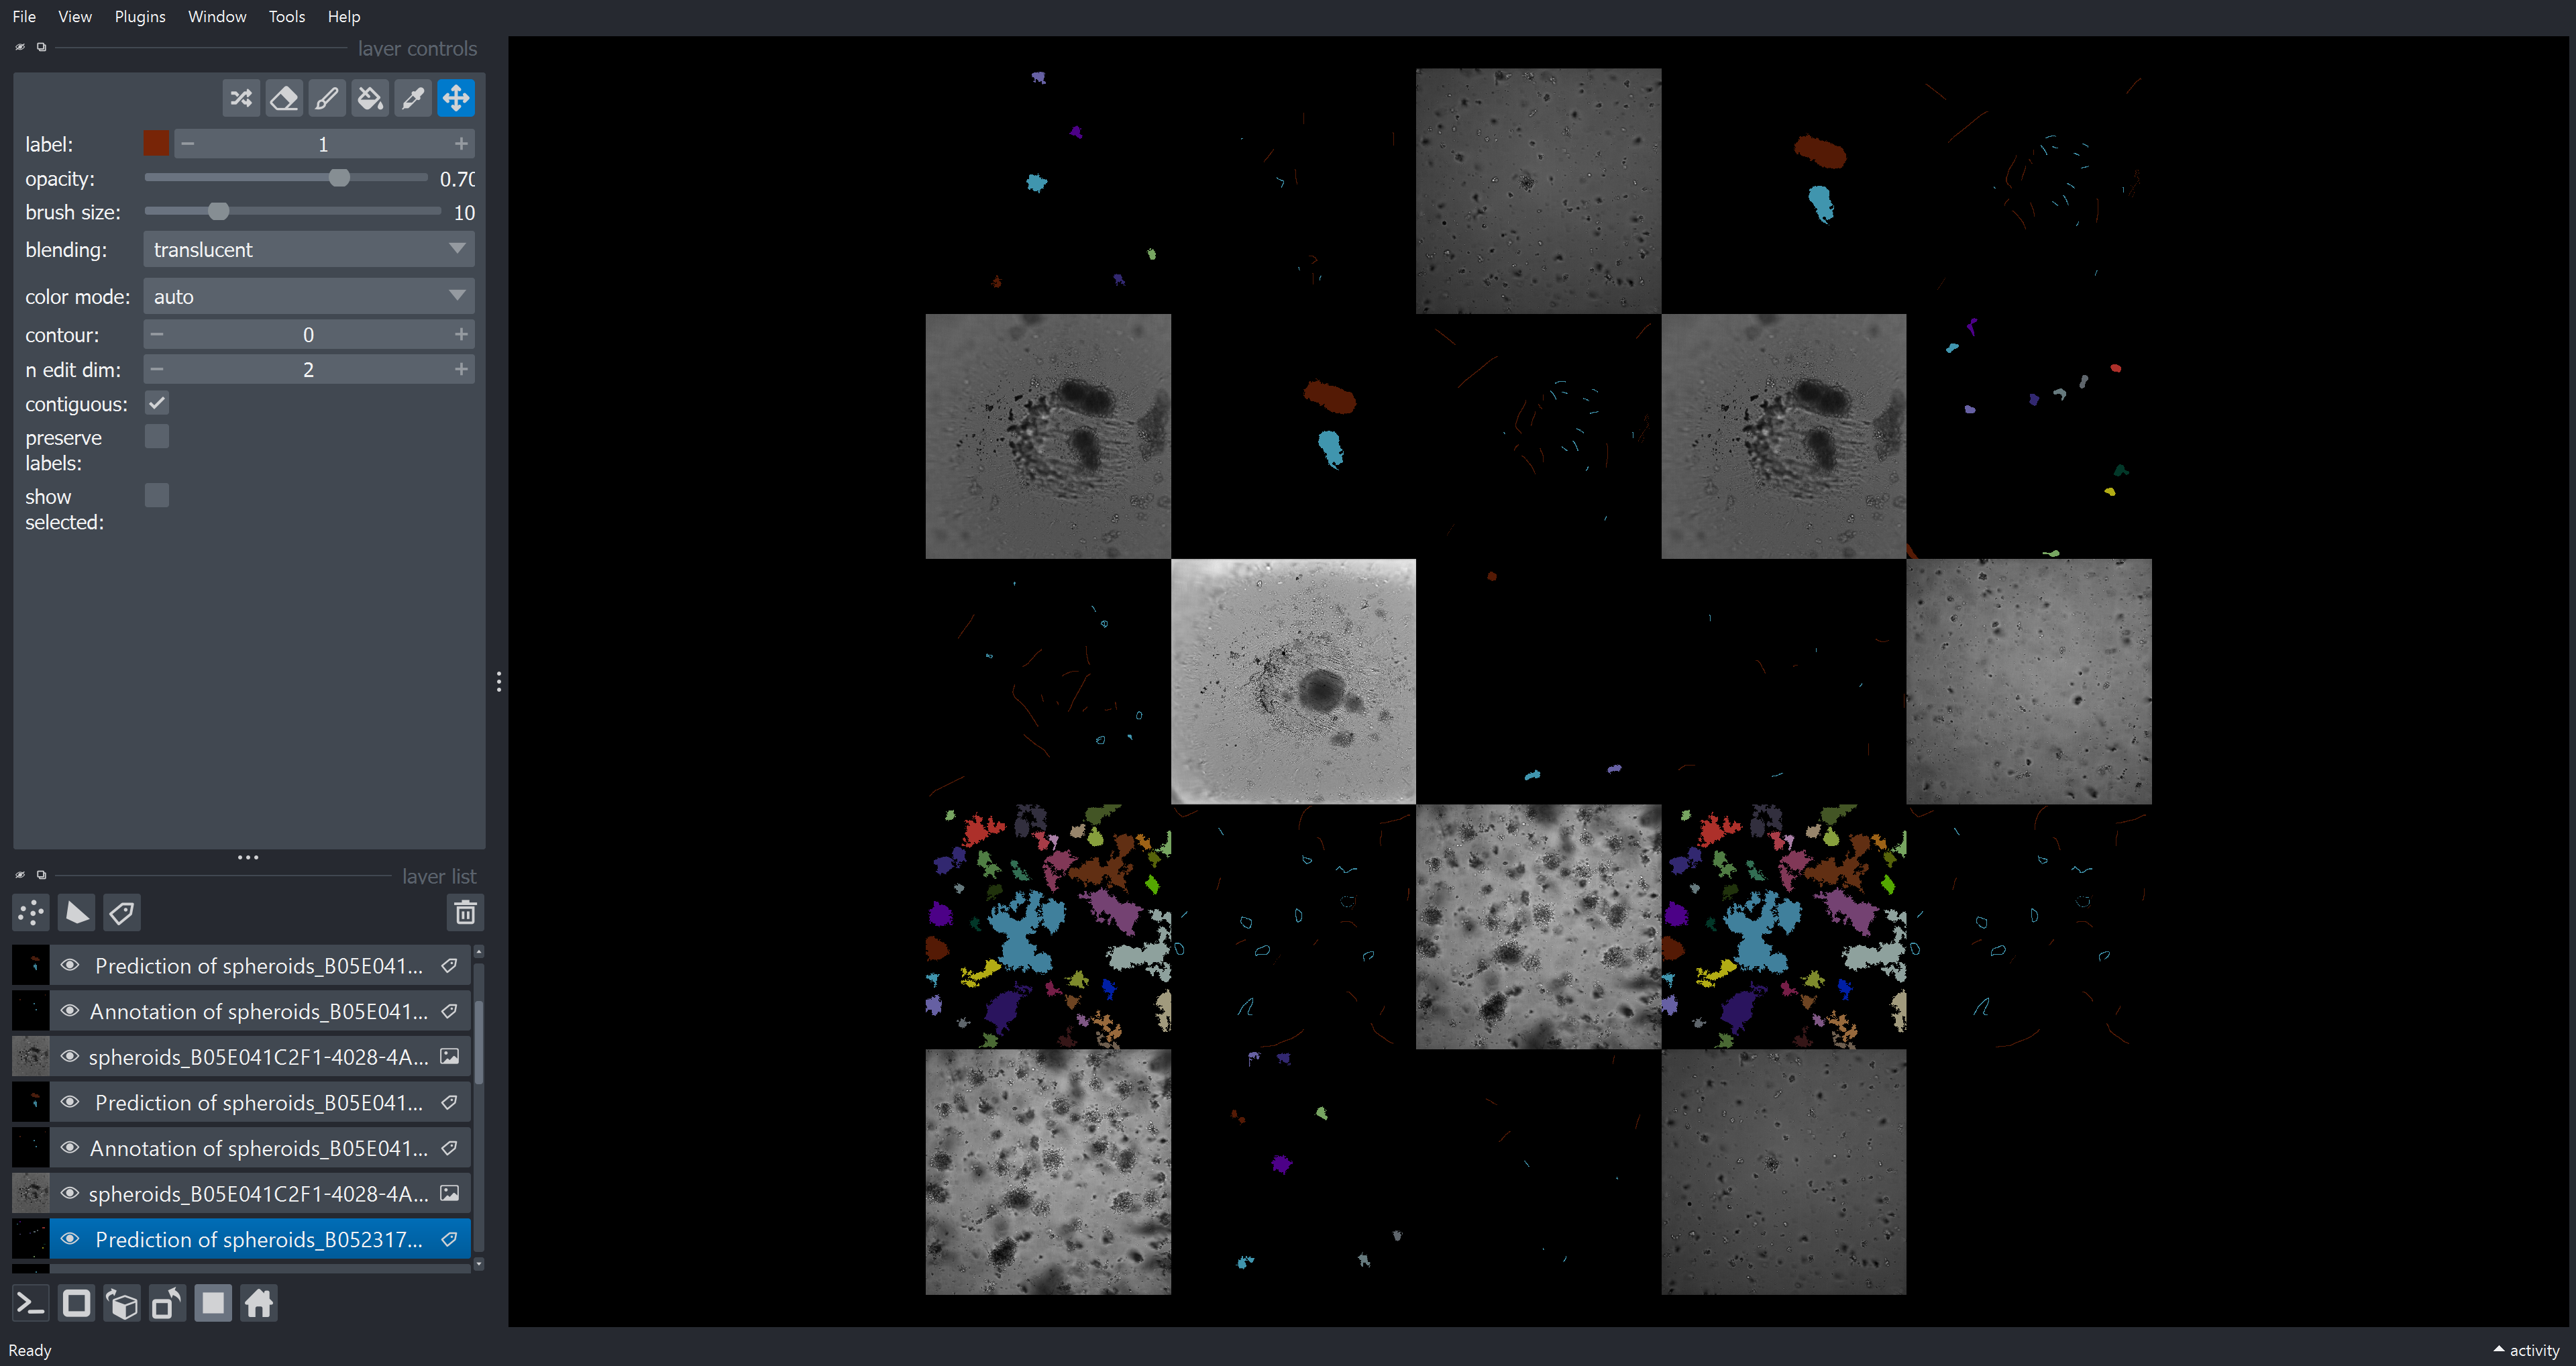

In [10]:
nbscreenshot(viewer)

## Improve annotations if necessary
Provide some extra annotations to images and re-run cells starting from **[4. Save annotations to disk](#4_save_annotations_to_disk)**.
